출처  :  
https://blog.naver.com/data_station/222493262626  
https://hongl.tistory.com/99

# 시계열 분석 (Time Series)

* 시간 : 특정 간격 갖는 시간 (Lag)
- Lag 에서 Data 의 Trend 를 찾음


### 시계열 분석 요소

* Trend : 추세
* Seasonality : 계절성
* Cycle : 주기
* Noise : 잡음 (시간에 독립적). 
    - white noise : 분석이 가능한 수준의 잡음

In [60]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('font', family="D2Coding")

In [61]:
df1 = pd.read_csv('../example_data/Data11.csv')
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 803675 entries, 0 to 803674
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   구매일     803675 non-null  object
 1   구매금액    803675 non-null  int64 
 2   물품대분류   803675 non-null  object
dtypes: int64(1), object(2)
memory usage: 18.4+ MB


In [62]:
df1.head()

,구매일,구매금액,물품대분류
0,2018-04-20,57120,기저귀
1,2018-04-20,15900,더블하트
2,2018-04-20,7000,더블하트
3,2018-04-20,20900,더블하트
4,2018-05-06,26500,더블하트


In [63]:
df1.tail() 

,구매일,구매금액,물품대분류
803670,2020-08-06,30960,더블하트
803671,2020-08-06,6640,더블하트
803672,2020-08-06,5600,더블하트
803673,2020-08-06,7840,더블하트
803674,2020-08-06,8500,기타


In [64]:
# 구매일 범위 확인을 위해 구매일 컬럼을 시간 형식으로 변경

df1['Datetime'] = pd.to_datetime(df1['구매일']) 

In [65]:
# Series 에서도 describe 적용 가능
# top - freq 최빈값과 횟수

df1['Datetime'].describe()

/Users/youranwoo/anaconda3/envs/adp/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  after removing the cwd from sys.path.


count                  803675
unique                    589
top       2019-10-11 00:00:00
freq                    10500
first     2018-04-20 00:00:00
last      2020-08-07 00:00:00
Name: Datetime, dtype: object

In [66]:
# 시간 형식으로 변형된 데이터를 통해 변수 파생

df1['Year'] = df1['Datetime'].dt.year
df1['Month'] = df1['Datetime'].dt.month
df1['Week'] = df1['Datetime'].dt.week
df1['Day_of_week'] = df1['Datetime'].dt.day_name()

/Users/youranwoo/anaconda3/envs/adp/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """


In [67]:
df1.head()

,구매일,구매금액,물품대분류,Datetime,Year,Month,Week,Day_of_week
0,2018-04-20,57120,기저귀,2018-04-20,2018,4,16,Friday
1,2018-04-20,15900,더블하트,2018-04-20,2018,4,16,Friday
2,2018-04-20,7000,더블하트,2018-04-20,2018,4,16,Friday
3,2018-04-20,20900,더블하트,2018-04-20,2018,4,16,Friday
4,2018-05-06,26500,더블하트,2018-05-06,2018,5,18,Sunday


<AxesSubplot:xlabel='Datetime', ylabel='구매금액'>

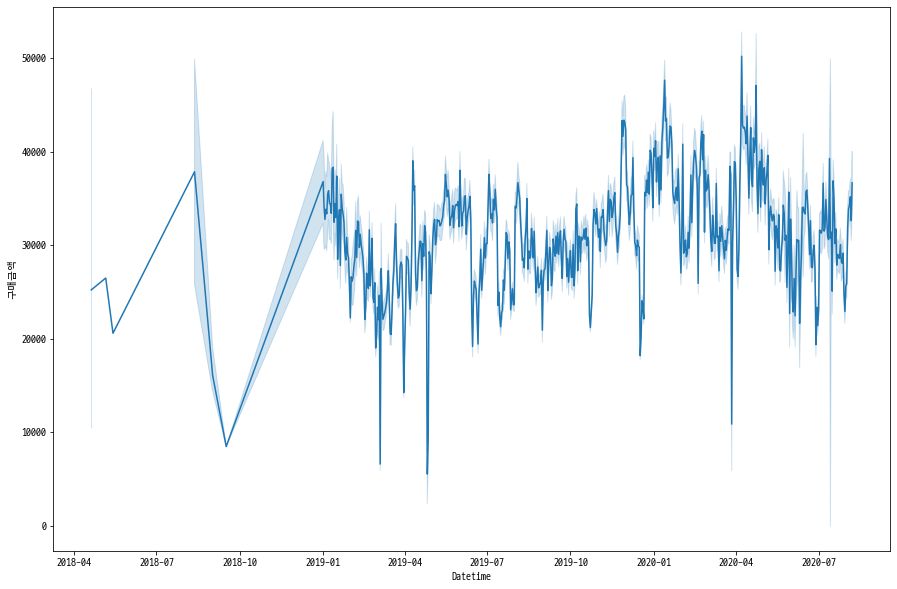

In [68]:
# 해당 날짜의 구매 금액 평균
sns.lineplot(data=df1, x='Datetime', y='구매금액')

KeyboardInterrupt: 

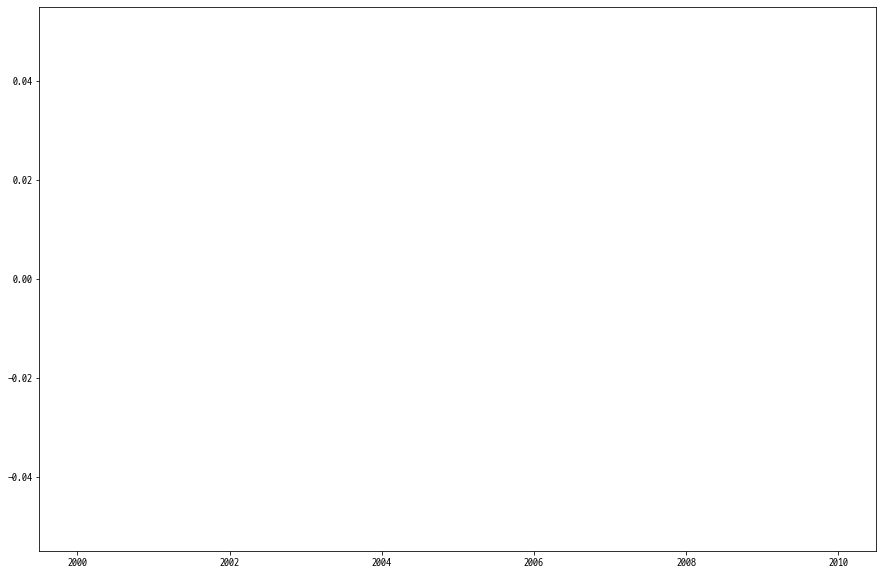

In [69]:
# 해당 날짜의 구매 금액 총합
sns.lineplot(data=df1, x='Datetime', y='구매금액', estimator=sum)

In [ ]:
# pivot 을 활용해서 그리기 -> lineplot 자체에서 계산하면 너무 오래걸리기 때문

p1 = pd.pivot_table(data=df1, 
index='Datetime', 
values='구매금액', 
aggfunc='sum').reset_index()

In [ ]:
p1.head()

,Datetime,구매금액
0,2018-04-20,100920
1,2018-05-06,26500
2,2018-05-14,20600
3,2018-08-12,75700
4,2018-09-01,48300


<AxesSubplot:xlabel='Datetime', ylabel='구매금액'>

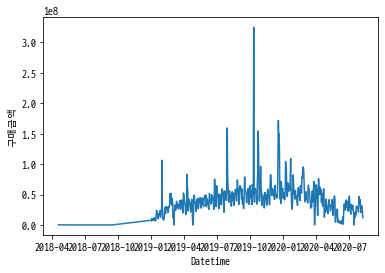

In [ ]:
sns.lineplot(data=p1, x='Datetime', y='구매금액')

In [ ]:
p2 = pd.pivot_table(data=df1, 
index= ['Datetime', '물품대분류'], 
values='구매금액', 
aggfunc='sum').reset_index()

In [ ]:
p2.head()

,Datetime,물품대분류,구매금액
0,2018-04-20,기저귀,57120
1,2018-04-20,더블하트,43800
2,2018-05-06,더블하트,26500
3,2018-05-14,FC,20600
4,2018-08-12,더블하트,75700


<AxesSubplot:xlabel='Datetime', ylabel='구매금액'>

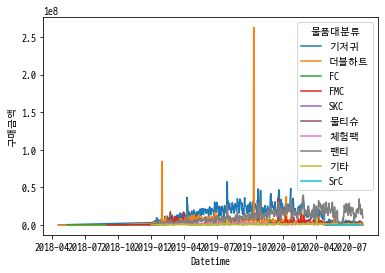

In [ ]:
sns.lineplot(data=p2, x='Datetime', y='구매금액', hue='물품대분류')

# [해설] 더블하트 급상승과 같은 요소는 특별한 이벤트에 의해 발생. 이후 예측에 영향을
# 끼치게 되면 예측력을 떨어뜨리므로 이를 방지하기 위해 이벤트를 제외하는 것이 좋다.

In [ ]:
# 물품대분류 == '기저귀'인 경우

cond1 = (df1['물품대분류']=='기저귀')
df2 = df1.loc[cond1].iloc[1:] # 2018-04-20 이후 한동안 데이터가 없다는 것을 확인 -> 데이터 삭제
df2.head()

,구매일,구매금액,물품대분류,Datetime,Year,Month,Week,Day_of_week
29,2019-05-13,59520,기저귀,2019-05-13,2019,5,20,Monday
30,2019-05-10,50640,기저귀,2019-05-10,2019,5,19,Friday
31,2019-06-06,50640,기저귀,2019-06-06,2019,6,23,Thursday
32,2019-07-01,50640,기저귀,2019-07-01,2019,7,27,Monday
33,2019-07-29,101280,기저귀,2019-07-29,2019,7,31,Monday


## ARIMA (Auto Regressive Integrated Moving Average Model)

* ARIMA = AR + MA + Difference
    * AR (Auto Regressive Model) : 자기 회귀 모델. p 시점 전의 자료가 현재 시점 데이터에 영향
        * ACF (AutoCorreltion Function) : 자기상관함수. 특정 구간 내 데이터 간 상관관계
        * PACF (Partial AutoCorreltion Function) : 부분자기상관함수. 과거 데이터가 지속적으로 영향을 주는 문제 보완
    * MA (Moving Average Model) : 이동 평균 모델. 일정한 구간 데이터의 평균을 계산해, 미래를 예측하는 모델 -> AR만 활용했을 때의 불규칙한 변동 제거
    *   Difference : 차분. 정상성을 만족하지 못하는 데이터(ex. 평균이 증가, 분산이 감소)를 정상적으로 변환

#
* ARIMA 활용 조건
    * 단기 예측에 적합
    * 계절적 변동 요인 (주기적 변동)
    * Sample > 50
    * 정상적 자료 <- 차분
        * 정상성(Stationarity) : 시계열의 평균과 분산 일정. 특정한 트렌드가 존재하지 않는 성질

In [ ]:
import statsmodels.tsa.api as tsa

In [ ]:
df2.head()

,구매일,구매금액,물품대분류,Datetime,Year,Month,Week,Day_of_week
29,2019-05-13,59520,기저귀,2019-05-13,2019,5,20,Monday
30,2019-05-10,50640,기저귀,2019-05-10,2019,5,19,Friday
31,2019-06-06,50640,기저귀,2019-06-06,2019,6,23,Thursday
32,2019-07-01,50640,기저귀,2019-07-01,2019,7,27,Monday
33,2019-07-29,101280,기저귀,2019-07-29,2019,7,31,Monday


In [ ]:
df_time = pd.pivot_table(data=df2, 
index='Datetime', 
values='구매금액', 
aggfunc='sum')

## Datetime이 인덱스로 잡혀있는게 분석할 때 편리!
#df_time = pd.pivot_table(data=df2, 
#index='Datetime', 
#values='구매금액', 
#aggfunc='sum').reset_index()
#df_time.set_index('Datetime')

df_time.head()

,구매금액
Datetime,
2019-01-01,3051240
2019-01-02,2556280
2019-01-03,2729480
2019-01-04,2238440
2019-01-05,2478680


In [ ]:
# 1일 단위의 평균 금액 계산
y = df_time['구매금액'].resample('1D').mean()

In [ ]:
# 결측값 확인
y.isnull().sum()

7

In [ ]:
# 결측값 있을 시 시계열에서는 
y1 = y.fillna( method='ffill' ) # method 'bfill' 또는 'ffill'

### 시계열 분해
* Trend (추세 요인)
* Seasonality (계절 요인)
* Residual (불규칙 또는 순환 요인)

In [ ]:
# 테이블 크기 조정

from pylab import rcParams
rcParams['figure.figsize'] = 15, 10

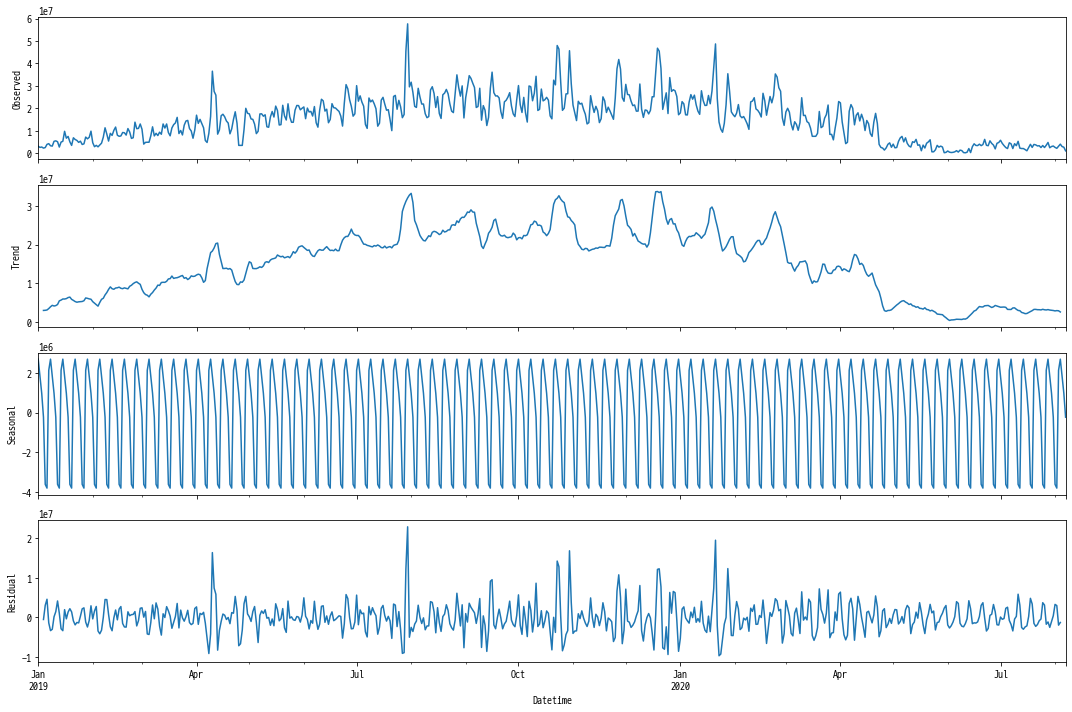

In [ ]:
# 시계열 모델 생성
model_series = tsa.seasonal_decompose(y1, model='additive')

# 모델 시각화
fig = model_series.plot()
plt.show()

In [ ]:
import itertools

* Likelihood (최대우도) : 특정 데이터가 모수로부터 추출되었을 가능도. 
    * 특정 값에 대한 분포의 확률 추정(연속확률밀도함수 pdf의 y값
#
* AIC (Akaike Information Criterion) : 데이터에 대한 모델의 상대적 품질 
    * AIC = -2 * ln (L) + 2k    (L은 Likelihood)
    * 값이 낮을수록 모형적합도가 높은 것을 의미
#
* BIC (Bayes Information Criterion) : 데이터에 대한 모델의 상대적 품질 
    * BIC = -2 * ln (L) + log(n) * p    (L은 Likelihood, n은 설명 변수의 수?)
    * BIC는 설명변수가 많을 때, 더 많은 패널티를 부여해 계산 
    * 값이 낮을수록 모형적합도가 높은 것을 의미
#
* HQIC (Hannan Quinn Information Criterion) : 데이터에 대한 모델의 상대적 품질 
    * HQIC = -2 * ln (L) + ln(ln(n)) * 2k
    * 값이 낮을수록 모형적합도가 높은 것을 의미

* Order (p, d, q), Seasonal Order (P, D, Q, M)
    #
    * p : AR에서의 p 값 (-> p 구간 내 데이터 사이의 상관 관계)
    * d : 차분
    * q : MA PACF 편상관계수 q 값
    #
    * P : 계절성 패턴 내에서의  P구간 내 데이터 사이의 상관 관계
    * D : 계절성 여부 
    * Q : 주기의 패턴이 얼마나 반복되는지
    * M : 계절성 주기의 값

In [ ]:
p = d = q = range(0,2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))

SARIMAX: (0, 0, 1) x (0, 0, 1, 12)


In [ ]:
param_list = []
param_seasonal_list = []
results_AIC_list = []

for param in pdq:
     for param_seasonal in seasonal_pdq:
        try:
            model = tsa.statespace.SARIMAX(y1,
                                        order=param,
                                        seasonal_order=param_seasonal,
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)
            results = model.fit()
            param_list.append(param)
            param_seasonal_list.append(param_seasonal)
            results_AIC_list.append(results.aic)
        except:
             continue

/Users/youranwoo/anaconda3/envs/adp/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


In [ ]:
ARIMA_list = pd.DataFrame({'Parameter':param_list,'Seasonal':param_seasonal_list,'AIC':results_AIC_list})

In [ ]:
ARIMA_list.head()

,Parameter,Seasonal,AIC
0,"(0, 0, 0)","(0, 0, 0, 12)",21187.142381
1,"(0, 0, 0)","(0, 0, 1, 12)",20486.120636
2,"(0, 0, 0)","(0, 1, 0, 12)",19898.386375
3,"(0, 0, 0)","(0, 1, 1, 12)",19300.897479
4,"(0, 0, 0)","(1, 0, 0, 12)",19901.464508


In [ ]:
ARIMA_list.sort_values(by='AIC').head(2)

,Parameter,Seasonal,AIC
43,"(1, 0, 1)","(0, 1, 1, 12)",18983.237154
47,"(1, 0, 1)","(1, 1, 1, 12)",18983.666911


In [ ]:
model = tsa.statespace.SARIMAX(y1,order=(1, 0, 1), 
                            seasonal_order=(0, 1, 1, 12),
                            enforce_stationarity=False, 
                            enforce_invertibility=False)
results = model.fit()

In [ ]:
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                               구매금액   No. Observations:                  585
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood               -9487.619
Date:                            Tue, 24 May 2022   AIC                          18983.237
Time:                                    09:37:10   BIC                          19000.542
Sample:                                01-01-2019   HQIC                         18989.995
                                     - 08-07-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5723      0.061      9.334      0.000       0.452       0.692
ma.L1          0.2837      0.073   

* Ljung-Box Test : 일정 기간 동안 관측치가 랜덤이고, 독립적인지 여부를 검정
    * 귀무가설 : 데이터가 상관관계를 나타내지 않음
    * 대립가설 : 데이터가 상관관계를 나타냄
    * P-value (귀무가설이 참일 확률) < 0.05(유의수준) -> 대립가설 참
#
* Jarque-Bera Test : 왜도와 첨도가 정규분포와 일치하는지 가설 검정
    * SARIMAX : 잔차의 분포가 정규분포인가
    * 귀무가설 : 해당 잔차는 정규분포와 일치한다.
    * 대립가설 : 해당 잔차는 정규분포와 일치하지 않는다.
    * P-value (귀무가설이 참일 확률) < 0.05(유의수준) -> 대립가설 참
    * 대립가설이 참인 경우는, 회귀로 설명할 수 없는 트렌드가 숨겨져 있다는 의미. 이 트렌드가 새로운 값을 예측할 때 영향을 줄 수 있음
# 
* Skew & Kurtosis
    * Skew : 왜도. 얼마나 뾰족한지
    * Kurtosis : 첨도. 얼마나 한쪽으로 쏠려있는지
#
* Hetroskedasticity (이분산 검정) : 잔차의 분산에 대한 이분산

* Warnings: -> 공분산행렬에 대한 설명
    * [1] Covariance matrix calculated using the outer product of gradients (complex-step). 
    -> 공분산행렬이 어떻게 계산됐느냐 
    * [2] Covariance matrix is singular or near-singular, with condition number 1.45e+45. Standard errors may be unstable. 
    -> 모수의 추정치가 불안정하다. 오버피팅이 발생했다. 오차의 변동이 심하다. 

### in-sample prediction

In [ ]:
# prediction : 마지막 7일 예측
# dynamic 파라미터는 in-sample 예측(학습한 데이터에 대한 예측)을 수행할 때, 예측값 대신 실제 값을 이용하겠다는 것을 의미

pred = results.get_prediction(start=pd.to_datetime('2020-08-01'), 
end=pd.to_datetime('2020-08-07'), 
dynamic=True)

In [ ]:
# 예측 결과 신뢰구간

pred_ci = pred.conf_int()
print(pred_ci)

              lower 구매금액    upper 구매금액
Datetime                              
2020-08-01 -1.017711e+07  1.665473e+07
2020-08-02 -1.347698e+07  2.184271e+07
2020-08-03 -1.492816e+07  2.275815e+07
2020-08-04 -1.405677e+07  2.437299e+07
2020-08-05 -1.480970e+07  2.386045e+07
2020-08-06 -1.423654e+07  2.451202e+07
2020-08-07 -1.492616e+07  2.384804e+07


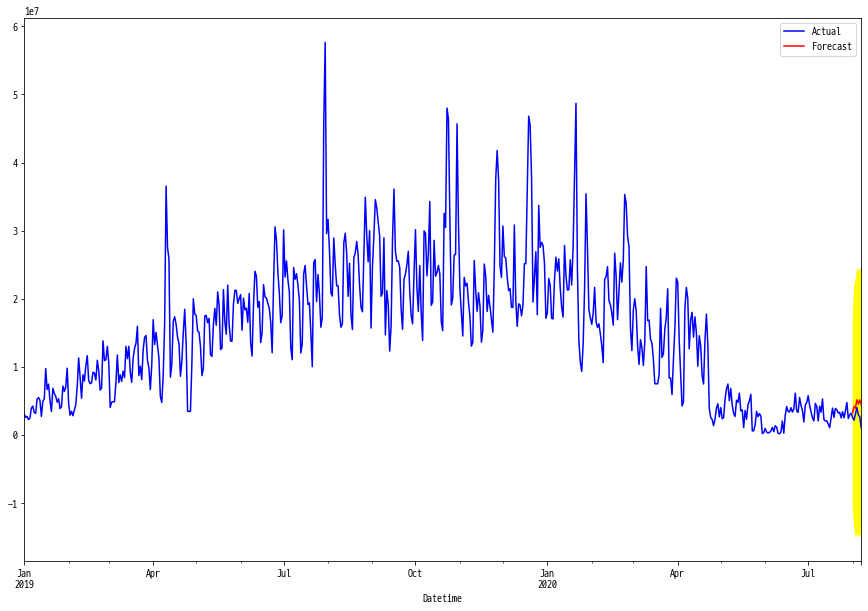

In [78]:
# 실제값과 예측값의 차이 시각화

y1.plot(figsize=(15,10), legend=True, label='Actual', color='blue')
ax = pred.predicted_mean.plot(figsize=(15,10), legend=True, label='Forecast', color='red')
ax.fill_between(pred_ci.index,pred_ci.iloc[:,0],pred_ci.iloc[:,1],color='yellow')

plt.show()

### out-of-sample prediction (w/ ".get_forcast")

In [80]:
# prediction : 이후 7일 예측
# dynamic 파라미터는 out-of-sample에서는 의미 없음

pred = results.get_prediction(start=pd.to_datetime('2020-08-08'), 
end=pd.to_datetime('2020-08-14'), 
dynamic=True)

TypeError: __new__() got an unexpected keyword argument 'start'